6/21/2022

Code to test bending mode implementation.

In [77]:
using Revise

In [1]:
# using MKL # should give a speed up. Check below that the MKL library actually loads. May cause error on Apple machines.
using JuliaSpectra
using Plots
using LinearAlgebra
using Parameters
BLAS.get_config()

┌ Info: Precompiling JuliaSpectra [3ef6d832-bae6-4172-b279-153036e5bc42]
└ @ Base loading.jl:1423


LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.0.3.13.dylib

In [2]:
bounds_a = (l=[-1,1], J = 1/2:3/2, I=1/2, Σ=[-1/2,1/2], Λ=0, S = 1/2, F=0:2, M=-2:2)
basisX_a = enumerate_states(LinearCaseA_Bend_Field, bounds_a)

bounds = (l=[-1,1], J = 1/2:3/2, I=1/2, N=1, Λ=0, S = 1/2, F=0:2, M=-2:2)
basisX = enumerate_states(LinearCaseB_Bend_Field, bounds)
;

In [3]:
@unpack B, γ, qv, bF, c, μa = MolParams["CaOH"]["X010"]
@consts begin
    sol = 29979.2458 # converts cm-1 to MHz.
    BX = B * sol
    γX = γ * sol
    qvX = qv * sol
    bFX = bF * sol
    cX = c * sol
    μel = μa
end
;

In [4]:
Elist = range(1e-1, stop=100, length=1250)

# X State
Hrot = BX * Rotation
Hsr = γX* SpinRotation
Hhf = (bFX+cX/3) * HyperfineFermi + cX * Hyperfine_Dipolar_c
Hld = qvX * lDoubling
HX0 = Hrot + Hsr + Hhf + Hld
@time eigsysX = eigenshuffle(HX0, μel*Stark, basisX, Elist, pack_eigensystem=true, warn_if_lost=true)
;

  5.086080 seconds (16.25 M allocations: 924.392 MiB, 4.61% gc time, 84.32% compilation time)


In [5]:
function conditions(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    parityop = build(Hamiltonian(basis=basis, H_operator = parity))
    Nlab = basis[argmax(abs2.(evecs))].N
    plab = Int64(round(evecs[:,1]' * parityop * evecs[:,1], digits=1))
    return (Nlab,plab)
end
Xinds = subspaceinds(eigsysX, conditions)

Dict{Any, Any} with 2 entries:
  (1//1, -1) => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  (1//1, 1)  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

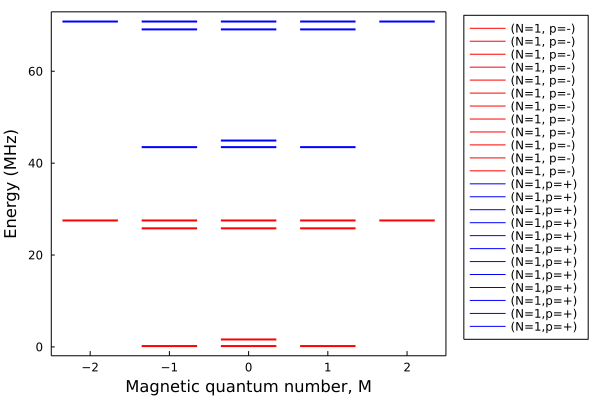

In [6]:
p=plotZeemanlevels(eigsysX[Xinds[1,-1],1], energy_offset = 9957, units="cm-1", ylabel="Energy", lw=2, color=:red, label="(N=1, p=-)")
plotZeemanlevels!(p,eigsysX[Xinds[1,1],1], energy_offset = 9957, units="cm-1",lw=2, color=:blue, label="(N=1,p=+)", legend=:outerright)
ylabel!("Energy (MHz)")

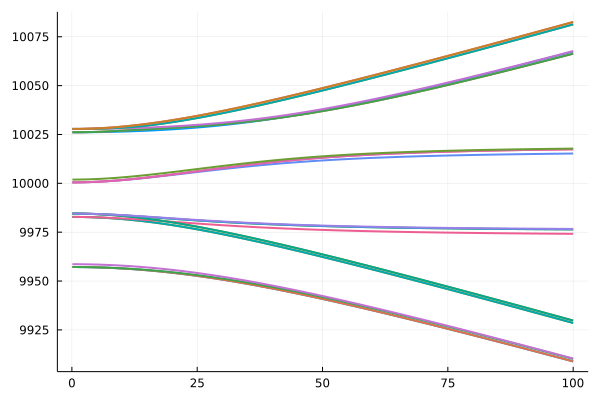

In [7]:
plot(Elist,eigsysX[1:24,:].E',legend=false, lw=2)

### Repeat in case (a) basis.

In [8]:
Elist = range(1e-2, stop=150, length=100)

# X State
Hrot = BX * Rotation
Hsr = γX* SpinRotation
Hld = qvX * lDoubling
HX0 = Hrot + Hsr + Hld
@time eigsysX_a = eigenshuffle(HX0, 1e-5*Zeeman, basisX_a, Elist, pack_eigensystem=true, warn_if_lost=true)
;

  0.451032 seconds (710.85 k allocations: 57.196 MiB, 70.72% compilation time)


In [9]:
function conditions(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    parityop = build(Hamiltonian(basis=basis, H_operator = parity))
    # Jlab = basis[argmax(abs2.(evecs))].J
    plab = Int64(round(evecs[:,1]' * parityop * evecs[:,1], digits=1))
    return (plab)
end
Xinds_a = subspaceinds(eigsysX_a, conditions)

Dict{Any, Any} with 2 entries:
  -1 => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 33, 34, 35, 36, 37, 38, 39, 40]
  1  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30…

Neglect hyperfine to make the plot below...

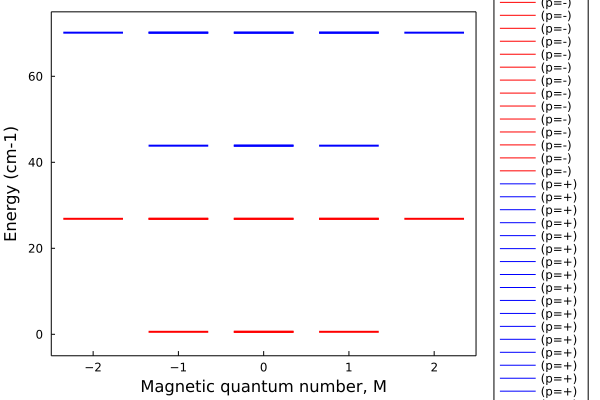

In [10]:
p=plotZeemanlevels(eigsysX_a[Xinds_a[-1],1], energy_offset = 9957, units="cm-1", ylabel="Energy", lw=2, color=:red, label="(p=-)")
plotZeemanlevels!(p,eigsysX_a[Xinds_a[1],1], energy_offset = 9957, units="cm-1",lw=2, color=:blue, label="(p=+)", legend=:outerright)
ylims!(-5,75)

# A state

In the basis of Li and Coxon, using a parity case (a) basis, you get a 4x4 block for each J labeled by the basis states $ \lvert ^2\Delta_{5/2}; \pm \rangle$,  $ \lvert ^2\Delta_{3/2}; \pm \rangle$, $ \lvert \kappa ^2\Sigma; \pm \rangle$, $ \lvert \mu ^2\Sigma; \pm \rangle$, where $\pm$ refers to e/f parity. So in a non-parity basis, each $J$ should give rise to an 8x8 block.

In [88]:
bounds = (l=[-1,1], J = 9/2, I=0, Λ=[-1,1], S = 1/2, M=1/2)
basis = enumerate_states(LinearCaseA_Bend_Field, bounds)


8-element Vector{LinearCaseA_Bend_Field}:
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>

Using the `VibronicManifold` struct to do this...

In [89]:
xstate = makevibronicmanifold(basisX, [(BX, Rotation),(γX,SpinRotation),(bFX+cX/3, HyperfineFermi),(cX,Hyperfine_Dipolar_c), (qvX, lDoubling),(0.0, μel*Stark)])

VibronicManifold{LinearCaseB_Bend_Field}(LinearCaseB_Bend_Field[|Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 0.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -2.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = 0.0>  …  |Λ = 0.0, l = 1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = 1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = 1.0, N = 1.0, S =

Make an eigenshuffle function that can act on vibronic manifolds. My idea is to have the vibronic manifold represent the "H0" part and the H1 to come from the scanned Hamiltonian term.

In [90]:
# function eigenshuffle(H0, H1, basis, params; pack_eigensystem=true, warn_if_lost=true)

# B(010)-X(010) rotational branching ratios
Let's calculate the relative rotational line strengths on the B(010) to X(010) transition.

In [91]:
boundsX = (l=[-1,1], J = 1/2:5/2, I=1/2, N=1:2, Λ=0, S = 1/2, F=0:3, M=-3:3)
basisX = enumerate_states(LinearCaseB_Bend_Field, boundsX)

boundsB = (l=[-1,1], J = 1/2:3/2, I=1/2, N=1, Λ=0, S = 1/2, F=0:2, M=-2:2)
basisB = enumerate_states(LinearCaseB_Bend_Field, boundsB)

24-element Vector{LinearCaseB_Bend_Field}:
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 0.0, M = 0.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = -1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 0.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = -1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 0.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -2.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = 0.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = 1.0>
 |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = 2.0>
 |Λ = 0.0, l = 1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.

In [92]:
molecule = "SrOH"

@unpack B, γ, bF, c, qv = MolParams[molecule]["X010"]
const BX = B * sol
const γX = γ * sol
const bFX = bF * sol
const cX = c * sol
const qvX = qv * sol

@unpack B, γ, bF, c, qv = MolParams[molecule]["B010"]
const BB = B * sol
const γB = γ * sol
const bFB = bF * sol
const cB = c * sol
const qvB = qv * sol
;

In [93]:
Elist = range(0.0001, stop=1, length=2)

# X State
Hrot = BX * Rotation
Hsr = γX* SpinRotation
Hhf = (bFX+cX/3) * HyperfineFermi + cX * Hyperfine_Dipolar_c
Hld = qvX * lDoubling
HX0 = Hrot + Hsr + Hhf + Hld
@time eigsysX = eigenshuffle(HX0, 1.0*Stark, basisX, Elist, pack_eigensystem=true, warn_if_lost=true)

# B state
Hrot = BB * Rotation
Hsr = γB* SpinRotation
Hhf = (bFB+cB/3) * HyperfineFermi + cB * Hyperfine_Dipolar_c
Hld = qvB * lDoubling
HB0 = Hrot + Hsr + Hhf + Hld
@time eigsysB = eigenshuffle(HB0, 1.0*Stark, basisB, Elist, pack_eigensystem=true, warn_if_lost=true)
;

Lost an eigenvector!
  0.057990 seconds (937.25 k allocations: 53.828 MiB)
  0.009699 seconds (147.82 k allocations: 8.275 MiB)


In [94]:
TDMDict = Dict{Int64,Array{Float64}}()
for p = -1:1
    Tmat = zeros(length(basisX), length(basisB))
    for (i,state) in enumerate(basisX)
        for (j,state′) in enumerate(basisB)
            Tmat[i,j] = TDM_E1(state,state′,p)
        end
    end
    TDMDict[p] = Tmat
end

In [95]:
function conditions(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    parityop = build(Hamiltonian(basis=basis, H_operator = parity))
    Jlab = basis[argmax(abs2.(evecs))].J
    Nlab = basis[argmax(abs2.(evecs))].N
    plab = Int64(round(evecs[:,1]' * parityop * evecs[:,1], digits=1))
    return (Nlab,Jlab,plab)
end
Xinds = subspaceinds(eigsysX, conditions)
Binds = subspaceinds(eigsysB, conditions)

Dict{Any, Any} with 4 entries:
  (1//1, 3//2, 1)  => [9, 10, 11, 12, 13, 14, 15, 16]
  (1//1, 1//2, -1) => [17, 18, 19, 20]
  (1//1, 3//2, -1) => [1, 2, 3, 4, 5, 6, 7, 8]
  (1//1, 1//2, 1)  => [21, 22, 23, 24]

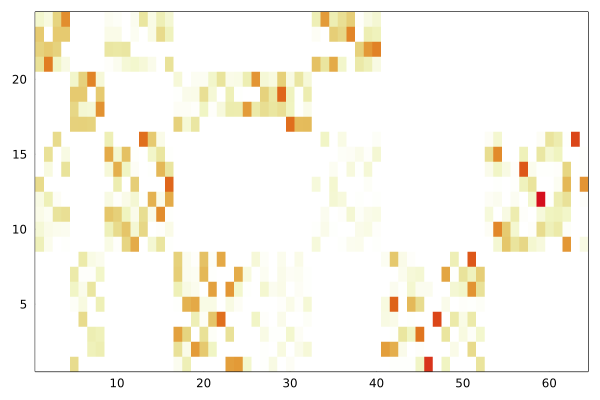

In [107]:
bv=1
output = branchingratios(eigsysX[:,bv], eigsysB[:,bv],TDMDict)
output = round.(output,digits=4)
heatmap(output', c=palette(:linear_wyor_100_45_c55_n256,rev=false), colorbar=false, legend=:false, framestyle=:box)

In [97]:
N1J12frac = sum(output[Xinds[1,1/2,-1],Binds[1,1/2,+1]])
N1J32frac = sum(output[Xinds[1,3/2,-1],Binds[1,1/2,+1]])
N2J32frac = sum(output[Xinds[2,3/2,-1],Binds[1,1/2,+1]])
total = N1J12frac + N1J32frac + N2J32frac
println("Decay to N=1, J=1/2: $(round.(N1J12frac/total,digits=3))")
println("Decay to N=1, J=3/2: $(round.(N1J32frac/total,digits=3))")
println("Decay to N=2, J=3/2: $(round.(N2J32frac/total,digits=3))")

Decay to N=1, J=1/2: 0.333
Decay to N=1, J=3/2: 0.166
Decay to N=2, J=3/2: 0.501


Expected values are 1/3, 1/6, and 1/2. So this agrees.